# Deep Unet
### Import packet 

In [1]:
import numpy as np 
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.utils import plot_model
from IPython.display import SVG
from tensorflow.python.framework import ops
from MAIN import *  # donde esta el modelo y las funciones necesarias como psnr y demas 
import scipy.io
import tensorflow as tf
from scipy.sparse import csr_matrix, find
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


2.0.0


# # Load sensing matrix and Data

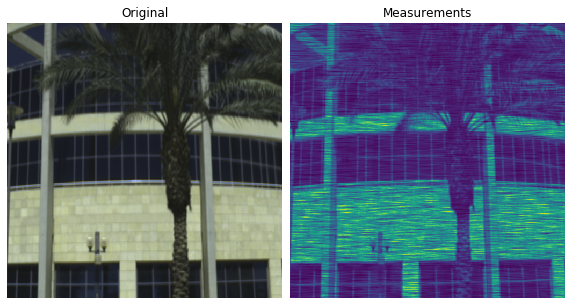

In [2]:
# load H
Mat= scipy.io.loadmat('H1ShotDriven.mat')
H = Mat['H']
[row,col,val] = find(H)
ind = np.asarray([row,col])
ind = np.transpose(ind,(1,0))

H_s = tf.SparseTensor(indices = ind, values = val, dense_shape=[H.shape[0], H.shape[1]])

# Load Data
Mat= scipy.io.loadmat('Palmera.mat')
testSI=np.double(Mat['hyperimg'])
testSI=testSI/np.max(testSI)
RGB = testSI[:,:,(25, 22, 11)]
[m,n,l]=testSI.shape

# Measurements
y = Hxfunction(tf.constant(testSI),largo=m,ancho=n,profun=l,H=H_s)
y = np.double(y.numpy())

fig, axs = plt.subplots(1,2,figsize=(10,10))
fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.03)


axs[0].imshow(RGB)
axs[0].axis('off')
axs[0].set_title('Original')


axs[1].imshow(y.reshape((m,n),order="F")/np.max(y))
axs[1].axis('off')
axs[1].set_title('Measurements')

del H

## AutoEncoder-Based

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


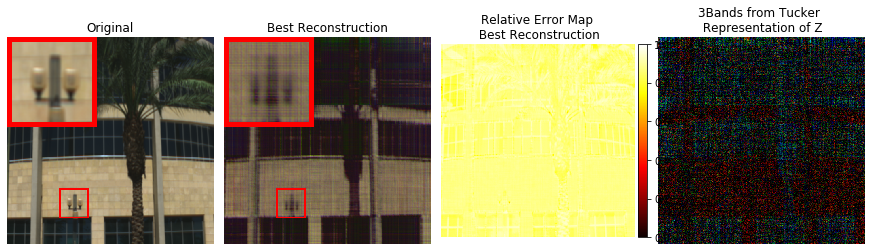

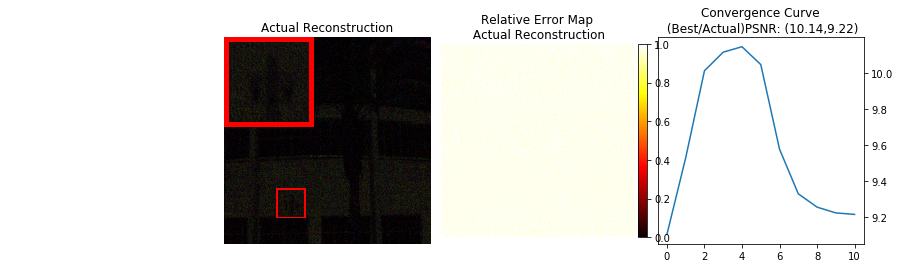

Epoch 00220: PSNR  9.214 : Max PSNR 10.144
Epoch 00240: PSNR  9.215 : Max PSNR 10.144
Epoch 00260: PSNR  9.217 : Max PSNR 10.144


KeyboardInterrupt: 

In [3]:
#Reconstruction Parameters setup
rho = 0.4
learning_rate = 1e-3
iters = 5000

#Visualization Parameters setup
Freq = 20

#Optimization
model=residualNet(input_size = (m,n,l), L=l,H=H_s, fact= rho)
optimizad = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9, amsgrad=False);
        
model.compile(optimizer=optimizad, loss='mean_squared_error')
model.fit(np.zeros(shape=(1,m,n,l)), y, epochs = iters,batch_size=1,callbacks=[myCallback(testSI,Freq)],verbose=0)
 
#Best Result
BestResult= model.Best
PSNR_Best = fun_PSNR(testSI,BestResult)

#Final Result
func = K.function([model.layers[0].input],[model.layers[len(model.layers)-2].output])
FinalResult = func(np.zeros(shape=(m,n,L)))
FinalResult = np.asarray(FinalResult).reshape((m,n,L),order="F")
PSNR_Final = fun_PSNR(testSI,FinalResult)

#Convergence Curve
PSNRs = model.PSNRs
PSNRs = PSNRs[1:len(PSNRs)-1]

#Low-Rank Tucker Representation of tensor Z
func = K.function([model.layers[0].input],[model.layers[1].output])
ZTuckerRepr = func(np.zeros(shape=(m,n,L)))
ZTuckerRepr = np.asarray(ZTuckerRepr).reshape((m,n,L),order="F")

#Visual Results
VisualGraphs(FinalResult,BestResult,ZTuckerRepr,PSNRs,testSI,[27,17,7])
    
